<a href="https://colab.research.google.com/github/ebernatene/faire-ai/blob/main/notebooks/FAIRE-AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ``faire.ai’s Data scientist case study``

![title](https://media-exp1.licdn.com/dms/image/C4E1BAQE8QiDVN5-7Ug/company-background_10000/0/1600070842318?e=2159024400&v=beta&t=nDy80t4g5XUry_JP1xbSXRkXayKhq52HlHrFxIDP3uo)

# Syntetic Data Points <a class="anchor" id="SynteticData"></a>

[Return tu index....](#index)


I define the class ``SyntheticData`` for create a synthetic dataset having 5k points. For reproducibility of the results it's posible set the parameter ``seed`` to initialize from the random state

In [ ]:
from numpy import random 
import pandas as pd


class SyntheticData:
  def __init__(self, seed):
    random.seed(seed)
            
  def generate_dataset(self,points):
    dataset = pd.DataFrame(columns=['sex','age','purchase','output'])
    dataset['age'] = random.random(size=1)<0.4
    dataset['sex'] = random.gamma(shape=8, scale=4, size=1)
    dataset['purchase'] = dataset.apply(lambda x: __purchase(x['age']))
    dataset['output'] = dataset.apply(lambda x: __output(x['age','sex','purchase']))
    
    return dataset

  def __purchase(self, age):
    return float(random.uniform(500,550,1)-10*age*random.uniform(-2,0.01,1))
        
  def __output(self,sex,age,purchase):
    prob = 0.3*sex+(0.2 if age>30 else 0.4)+(0.3 if purchase>100 else 0)
    return int(random.random(size=1)<prob)

In [ ]:
SEED = 123

gen = SyntheticData(seed=SEED)
data = gen.generate_dataset(5000)

data.head()

,sex,age,purchase,output
0,0.0,21.0,777.380212,0.0
1,0.0,23.0,820.954679,0.0
2,0.0,29.0,986.853758,1.0
3,0.0,24.0,672.994341,1.0
4,0.0,20.0,661.033301,1.0


# Exploratory <a class="anchor" id="exploratory"></a>

[Return tu index....](#index)

Before to initialize to work I will check some aspects of the dataset generated. First I check that there isn't NULL's values. Second I check that the proportion in the feature "sex" is consistent with a distribution ``Bernoulli(p=0.4)``. Thirst that the distribution of the feature "age" is consistent with a distribution ``Gamma($\alpha$ = 8, $\theta$ = 4)``. I don't want to do any calculations, just a quick visual inspection.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import gamma
import numpy as np

sns.set_style("whitegrid")
%matplotlib inline

In [ ]:
# Check!
print("Quantity of NULL values")
print("---"*10)
print(data.isnull().sum())

Quantity of NULL values
------------------------------
sex         0
age         0
purchase    0
output      0
dtype: int64


Text(0.5, 1.0, 'SEX')

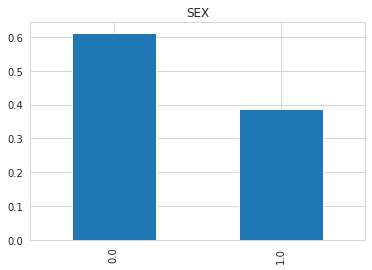

In [ ]:
# Check!
data['sex'].value_counts(normalize=True).plot.bar()
plt.title('SEX')

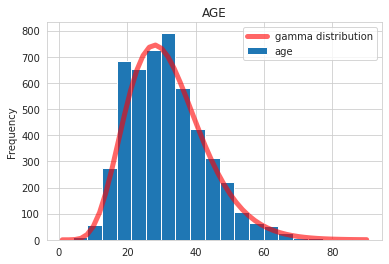

In [ ]:
# Check!

# Data
data['age'].plot.hist(bins=20)

x = np.linspace(1,90)
# Theoretical distribution "aprox"
plt.plot(x, gamma.pdf(x, 8,0,4)*20000,'r-', lw=5, alpha=0.6, label='gamma distribution')

plt.title('AGE')
plt.legend()

In [ ]:
print('Quantity by Class:')
print("---"*10)
print(data['output'].value_counts())

Quantity by Class:
------------------------------
1.0    3592
0.0    1408
Name: output, dtype: int64


Text(0.5, 1.0, 'Purchase')

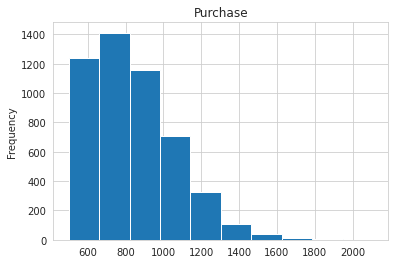

In [ ]:
data['purchase'].plot.hist()
plt.title('Purchase')

## Balance of class

As result of generate 5K points using the funtion `SyntheticData` with `seed=123`, I obtain `3592 cases for class 1` and `1408 cases for class 0`, with an approximated `ratio of "2.3:1"`.
Although the balance of classes in the dataset gives a ratio not very near to <b>"1"</b>, it's not different enough how to be shure about the need to apply specific strategies to solve the problem. As a first approach I will leave them.

Text(0.5, 1.0, 'Balance of Class')

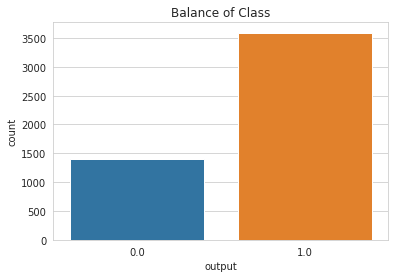

In [ ]:
sns.countplot(data=data,x='output')
plt.title('Balance of Class')

Although the proportion of "Female" and "Male" is balanced in the dataset, its distribution between class 1 and class 2 is very different. "Female" is more balanced in both classes respect to "Male", which mostly belong to class 1. The feature "sex" present a good capacity to split both classes in two for "Male", however this could limit the model to work with the others variables. If we thinks as in a decision tree, the next step will receive an imbalanced problem. A posible aproach to improve for future could be used a model for each sex with a treatment for imbalanced data. 

Text(0.5, 1.0, 'Balance of Class by "sex"')

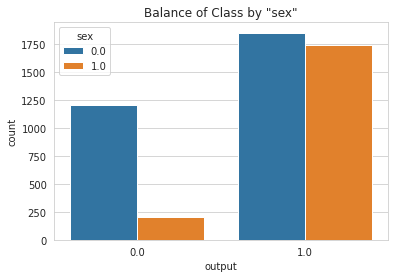

In [ ]:
sns.countplot(data=data,x='output',hue='sex')
plt.title('Balance of Class by "sex"')

## Correlación de las variables

Comprender la estructura intrínseca de un conjunto de datos ayuda a definir estrategias para abordar la resolución del problema. Es por esto que continuaré viendo que otra información podemos extraer.

Las siguientes grillas de gráficos corresponden a la distribución de los casos, primero para "Hombre" y luego para "Mujer". 
En el caso de los "hombres" se observa como la superposición de las distribuciones para las clases "0" y "1" es grande, tanto para las variables "age" como para "purchase". Se observan diferencias entre ambas pero no muy grandes, lo que anticipa que las soluciones al problema serán de bajo rendimiento. 
Lo mismo ocurre para el caso de "mujeres" donde la superposición entre las distribuciones es casi completa. Sin embargo, cuando se comparan los mismos gráficos entre "hombre" y "mujer" se logran ver pequeñas diferencias.
En el caso del feature "age" es el más evidente, donde la distribución de la clase "0" para "hombres" no alcanza valores demasiado bajos de edad.

In [ ]:
diag_kind{‘auto’, ‘hist’, ‘kde’, None}
diag_kws

Text(0.5, 0.98, 'Distribution of Cases for "Male" (sex=1)')

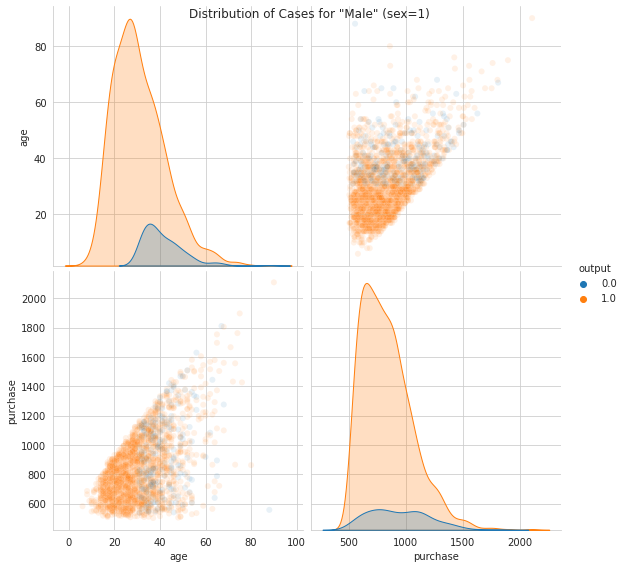

In [ ]:
# Distribution of Cases for Male (sex=1)
g = sns.pairplot(data.loc[data['sex']==1], 
                 vars=['age','purchase'], 
                 hue="output", 
                 height=4,
                 diag_kind='auto',
                 plot_kws={'alpha':0.1})
g.fig.suptitle('Distribution of Cases for "Male" (sex=1)')

Text(0.5, 0.98, 'Distribution of Cases for "Female" (sex=0)')

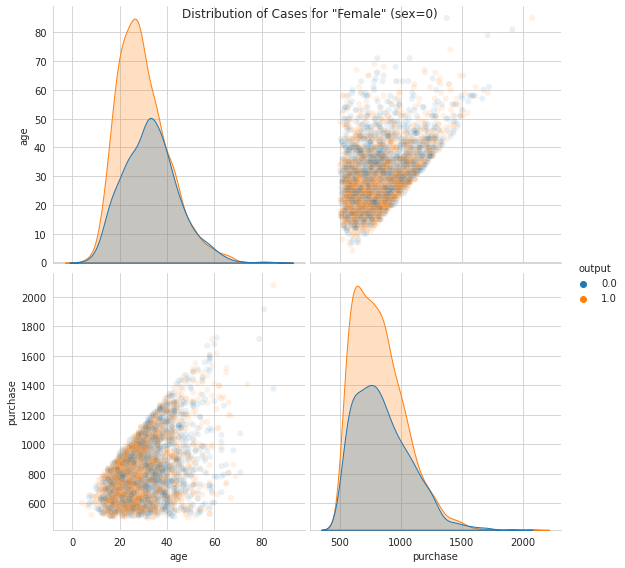

In [ ]:
# Distribution of Cases for Female (sex=0)
g = sns.pairplot(data.loc[data['sex']==0], 
                 vars=['age','purchase'], 
                 hue="output", 
                 height=4,plot_kws={'alpha':0.1})
g.fig.suptitle('Distribution of Cases for "Female" (sex=0)')

from the correlation matrix plot I can deduce that feature "sex" is independent of the other two, however features "age" and "purchase" are correlated with a significant value. From here we can deduce that the implementation of a Logistic Regression Model will need some kind of regularization.

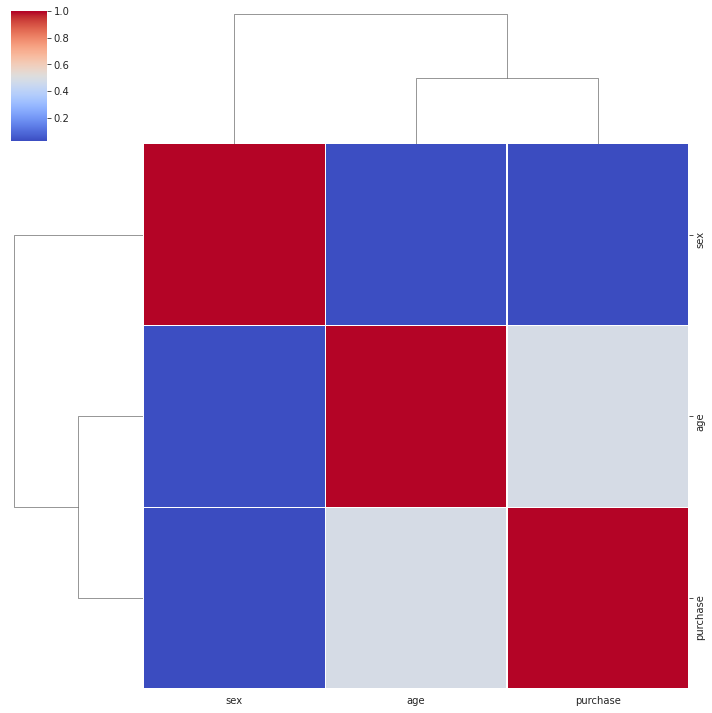

In [ ]:
corr = data.drop(['output'], axis=1).corr()
sns.clustermap(corr, cmap ='coolwarm', linewidths = 0.2,
                    method = 'complete')

# Construction of the models <a class="anchor" id="models"></a>

[Return to index...](#index)

Before to start to constructs the models I will separate in ``train`` and ``test`` the dataset. I need construct a model to resolve the problem and at the same time I need test its performance. Work in both stages with all the dataset will generate ``overfiting``, thats means over-adjust the solution to the this particular dataset, losing predictive power.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X, y = data.drop(['output'], axis=1), data[['output']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

## Logistic Regression <a class="anchor" id="logreg"></a>

[Return to index...](#index)

### Preprocessing

In general, learning algorithms benefit from standardization of the data set. For instance,  the "l1" and "l2" regularizers of linear models assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. Because of this, the numeric variables "age" and "purchase" in the dataset are preprocessed with the `StandardScaler` function prior to their use in the model. In the case of the categorical variable "sex" I don't need make nothing because it already has the format of ``OneHotEncoding``.

In [ ]:
numeric_columns = ['age','purchase']
categoric_columns = ['sex']

numeric_transformer = Pipeline(steps=[('scaler',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_columns)],
                                 remainder='passthrough')

### Model

In [ ]:
model = LogisticRegression(solver = 'liblinear',max_iter=1000)

### Pipeline

In order to define the flow of data from one stage to the other, I will use the `Pipeline` function.

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessing',preprocessor),
    ('classificator',model)
])

### Grid Search

Grid Search in an Exhaustive search over all specified parameter values for an estimator. 


Logistic regression requires there to be little or no multicollinearity among the independent variables.  This means that the independent variables should not be too highly correlated with each other. Unfortunately variables "age" and "purchase" are correlated. For deal with this problem is necesary penalize correlated variables through some regularization term added to the loss funtion. In the model, hyperparameter `penalty` permit select between a family of them ("l1", "l2" and "elastic-net"). In the problem I will work only with "l1" and "l2". Regularization has another hiperparameter asociated `C` which regulates how strength is the penalty for the correlated variables. 


<b>Resume of Hyperparameters to use   in this work:</b>

* ``penalty`` : 
    Specify the regularization that is applied.

* ``C`` : 
    Inverse of regularization strength.

* ``class_weight`` : 
    Adjust weights inversely proportional to class frequencies in the input data
    as ``n_samples / (n_classes * np.bincount(y))``.

In [ ]:
lr_C =  [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,100,1000]
reg = ['l1','l2']

## defino los hyperparámetros que voy a recorrer
param_grid = [
  {'classificator__C':lr_C, 'classificator__penalty':reg}
]

If 

In [ ]:
def count_models_to_train(param_grid):
  quantity = 1
  for param in param_grid[0].keys():
    quantity *= len(param_grid[0][param])
  return quantity

print('WARNING!!!')
print(f'Quantity of model to train : {count_models_to_train(param_grid)}')

WARNING!!!
Quantity of model to train : 22


In [ ]:
CV = 5

search = GridSearchCV(pipeline, param_grid, 
                      cv=CV,return_train_score = True,
                      scoring = 'roc_auc').fit(X_train, y_train['output'].ravel())

### Best Model Found

After an exhaustive search over all specified hyperparameter values the best model found correspond to ``C=0.005`` and ``penalty='l1'``. But the range of values evaluates was huge in insignificant number of points, I just has a better idea respect to range of values where to search. It's posible iterate in a new Grid Search after analyze but for this example I will just leave it as a suggestion.

In [ ]:
search.best_estimator_['classificator']

LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
results = pd.DataFrame(search.cv_results_)

In [ ]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classificator__C,param_classificator__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.010647,0.000772,0.006286,0.000409,0.001,l1,"{'classificator__C': 0.001, 'classificator__pe...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,22,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
1,0.014648,0.001345,0.007332,0.000628,0.001,l2,"{'classificator__C': 0.001, 'classificator__pe...",0.734513,0.686114,0.711714,0.748460,0.717952,0.719751,0.021173,21,0.718262,0.729341,0.718987,0.717615,0.719890,0.720819,0.004328
2,0.016262,0.004534,0.008038,0.001289,0.005,l1,"{'classificator__C': 0.005, 'classificator__pe...",0.745240,0.696236,0.738369,0.748746,0.739416,0.733601,0.019066,1,0.730332,0.742511,0.731930,0.729562,0.731852,0.733238,0.004724
3,0.014702,0.003889,0.007858,0.001560,0.005,l2,"{'classificator__C': 0.005, 'classificator__pe...",0.740919,0.690303,0.726825,0.748916,0.730164,0.727426,0.020149,20,0.725098,0.737447,0.725852,0.724373,0.726618,0.727877,0.004843
4,0.013421,0.001064,0.006909,0.000496,0.01,l1,"{'classificator__C': 0.01, 'classificator__pen...",0.744677,0.695896,0.737805,0.748723,0.739277,0.733276,0.019091,2,0.730260,0.742180,0.731064,0.729392,0.731405,0.732860,0.004711


In [ ]:
l1_results = results.loc[results.param_classificator__penalty=='l1']
l2_results = results.loc[results.param_classificator__penalty=='l2']

In [ ]:
def plot_train_test(results, parameter, cv, color , label):
    
    param_C = results[f'param_classificator__{parameter}']
    
    perf_train = results['mean_train_score']
    std_train = results['std_train_score']*1.96/np.sqrt(cv)
    ylow_train =   perf_train - std_train
    yup_train = perf_train + std_train
    
    perf_test = results['mean_test_score']
    std_test = results['std_test_score']*1.96/np.sqrt(cv)
    ylow_test =   perf_test - std_test
    yup_test = perf_test + std_test
    
    try:
        ax
    except:
        fig, ax = plt.subplots(1)
    
    ax.plot(param_C,perf_train,color=color , label=f'{label}-train')
    ax.fill_between(param_C.astype(float), 
                    yup_train, 
                    ylow_train, 
                    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
    
    ax.plot(param_C,perf_test, color=color, linestyle='--', label=f'{label}-validation')
    ax.fill_between(param_C.astype(float), 
                    yup_test, 
                    ylow_test, 
                    alpha=0.5, edgecolor='lightgray', facecolor='lightgray')
    plt.xlabel(parameter)
    plt.ylabel('mean')
    plt.legend()

(0.7, 0.75)

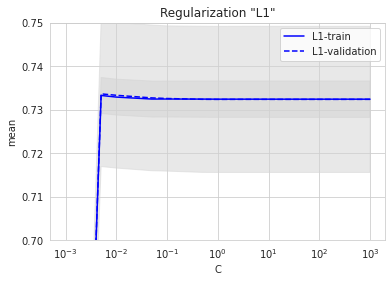

In [ ]:
plot_train_test(l1_results, parameter='C', cv=CV,color='blue', label="L1")
plt.xscale('log')
plt.title('Regularization "L1"')
plt.ylim(0.70,0.75)

(0.7, 0.75)

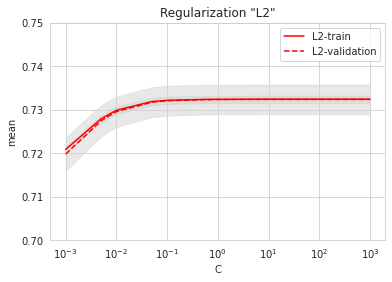

In [ ]:
plot_train_test(l2_results, parameter='C', color='red', label="L2")
plt.title('Regularization "L2"')
plt.xscale('log')
plt.ylim(0.70,0.75)

## Random Forest <a class="anchor" id="randomforest"></a>

[return to index...](#index)

### Preprocessing

Random Forest is a tree-based model and hence does not require feature scaling

### Model

In [ ]:
model = RandomForestClassifier(random_state=SEED,max_features=None)

### Pipeline

If well in this situation I don't need really use pipeline to define the flow of data because there is just one stage, I prefer use it because is more easy to modificate if I want do it in future.

In [ ]:
pipeline = Pipeline(steps=[
    ('classificator',model)
])

## Optimization of Hyperparameters

Random Forest is a tree-based model and therefore many hyperparameters are related to a single tree. However, the strength of this model is that it also works on the concept of ensamble, that means many trees differents. To generate ensambles, the model uses another set of hyperparameters.


The most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features)





## Hyperparameters

* ``n_estimators`` : 
    The number of trees in the forest.

* ``max_depth`` : 
    The maximum depth of the tree.

* ``min_samples_split`` : 
    The minimum number of samples required to split an internal node:

* ``min_samples_leaf`` : 
    The minimum number of samples required to be at a leaf node.

* ``max_features`` : 
    The number of features to consider when looking for the best split.

* ``min_impurity_decrease`` :
    A node will be split if this split induces a decrease of the impurity
    greater than or equal to this value.

* ``class_weight`` : Adjust weights inversely proportional to class frequencies 
    in the input data as :
    ``n_samples / (n_classes * np.bincount(y))``.


### Grid Search

In [ ]:
# The number of trees in the forest.
n_estimators = np.array([5, 10, 20 , 50, 100, 500, 1000])
min_samples_split = np.linspace(0.01, 0.1, 10, endpoint=True)
# The maximum depth of the tree.
max_depth = [5,10,50]#np.lspace(1, 5, 5, endpoint=True)
min_impurity_decrease = np.linspace(0,0.02, 20, endpoint=True)

param_grid = [
  {'classificator__n_estimators':n_estimators,
   'classificator__min_samples_split':min_samples_split,
   'classificator__max_depth':max_depth,
   'classificator__min_impurity_decrease':min_impurity_decrease}
 ]

In [ ]:
print('WARNING!!!'*10)
print(f'Quantity of model to train : {count_models_to_train(param_grid)}')

WARNING!!!WARNING!!!WARNING!!!WARNING!!!WARNING!!!WARNING!!!WARNING!!!WARNING!!!WARNING!!!WARNING!!!
Quantity of model to train : 4200


In [ ]:
search = GridSearchCV(pipeline, param_grid, 
                      cv=5,return_train_score = True,
                      scoring = 'roc_auc').fit(X_train, y_train['output'].ravel())

### Best Model

In [ ]:
best_params = search.best_estimator_['classificator'].get_params()
best_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.004210526315789474,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.01,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [ ]:
results = pd.DataFrame(search.cv_results_)results

In [ ]:
n_estim_result = results.loc[(results['param_classificator__max_depth']==best_params['max_depth']) & \
                             (results['param_classificator__min_samples_split']==best_params['min_samples_split']) & \
                             (results['param_classificator__min_impurity_decrease']==best_params['min_impurity_decrease'])]

Text(0.5, 1.0, 'N-Estimators (best = 10)')

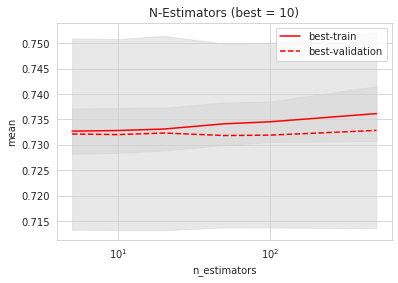

In [ ]:
plot_train_test(n_estim_result, parameter='n_estimators',color='red',label='best')
plt.xscale('log')
plt.title('N-Estimators (best = 10)')

In [ ]:
min_sample_split_results = results.loc[(results['param_classificator__max_depth']==best_params['max_depth']) & \
                                       (results['param_classificator__n_estimators']==best_params['n_estimators']) & \
                                       (results['param_classificator__min_impurity_decrease']==best_params['min_impurity_decrease'])]

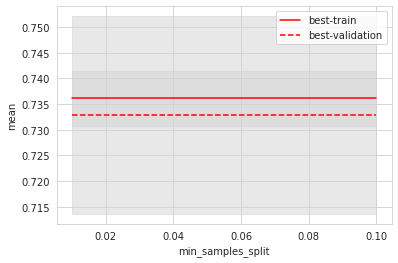

In [ ]:
plot_train_test(min_sample_split_results, parameter='min_samples_split',color='red',label='best')

In [ ]:
max_depth_results = results.loc[(results['param_classificator__n_estimators']==best_params['n_estimators']) & \
                             (results['param_classificator__min_samples_split']==best_params['min_samples_split']) & \
                             (results['param_classificator__min_impurity_decrease']==best_params['min_impurity_decrease'])]

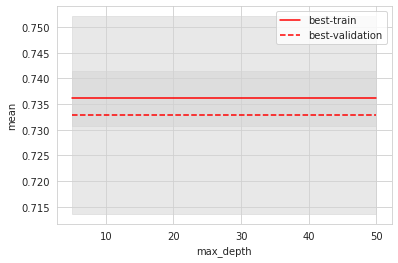

In [ ]:
plot_train_test(max_depth_results, parameter='max_depth',color='red',label='best')

In [ ]:
min_impurity_decrease_results = results.loc[(results['param_classificator__max_depth']==best_params['max_depth']) & \
                             (results['param_classificator__min_samples_split']==best_params['min_samples_split']) & \
                             (results['param_classificator__n_estimators']==best_params['n_estimators'])]

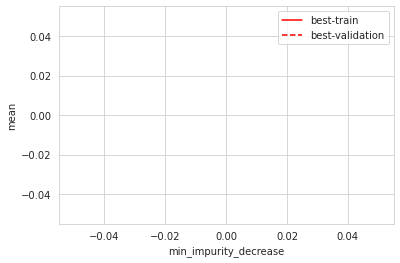

In [ ]:
plot_train_test(min_impurity_decrease_results, parameter='min_impurity_decrease',color='red',label='best')

## Evaluations <a class="anchor" id="evals"></a>

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
pipeline = Pipeline(steps = [('clasificador',RandomForestClassifier(random_state = SEED,n_estimators = 50))])

In [ ]:
rfcv = cross_val_score(pipeline, X_train, y_train['output'].ravel(), cv=5,scoring = 'roc_auc')
print(np.mean(rfcv),np.std(rfcv))


0.6621509562702949 0.016085225024834414


In [ ]:
'param_classificator__n_estimators',
'param_classificator__min_samples_split',
'param_classificator__max_depth',
'param_classificator__min_impurity_decrease'

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
for param, values in random_grid.items():
    print(f'{param}: {values}')

n_estimators: [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
max_features: ['auto', 'sqrt']
max_depth: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
bootstrap: [True, False]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV